In [1]:
from google.colab import files
files.upload()

Saving SGDW.py to SGDW.py
Saving RAdam.py to RAdam.py
Saving OneCycle.py to OneCycle.py
Saving Lookahead.py to Lookahead.py
Saving CLR.py to CLR.py
Saving AdamW.py to AdamW.py


{'AdamW.py': b'import math\nimport torch\nfrom torch.optim.optimizer import Optimizer\n\nclass AdamW(Optimizer):\n    r"""Implements Adam algorithm with decoupled weight decay.\n\n    It has been proposed in `DECOUPLED WEIGHT DECAY REGULARIZATION`_.\n    Below is modification of adam code from pytorch repository(https://github.com/pytorch/pytorch)\n\n    Arguments:\n        params (iterable): iterable of parameters to optimize or dicts defining\n            parameter groups\n        lr (float, optional): learning rate (default: 1e-3)\n        betas (Tuple[float, float], optional): coefficients used for computing\n            running averages of gradient and its square (default: (0.9, 0.999))\n        eps (float, optional): term added to the denominator to improve\n            numerical stability (default: 1e-8)\n        weight_decay (float, optional): weight decay (default: 0)\n        amsgrad (boolean, optional): whether to use the AMSGrad variant of this\n            algorithm from t

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [0]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import math
import tqdm as tqdm
from Lookahead import Lookahead
from AdamW import AdamW
from RAdam import RAdam

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
np.random.seed(17)

# Load Dataset

In [0]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

In [0]:
normalize = transforms.Normalize(mean=mean, std=std)
train_transforms = transforms.Compose([
                    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize
                ])
valid_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    normalize
                ])

In [8]:
trainset = CIFAR10('./data', train=True, download=True, transform=train_transforms)
testset = CIFAR10('./data', train=False, download=True, transform=valid_transforms)

0it [00:00, ?it/s]

 99%|█████████▊| 167944192/170498071 [00:11<00:00, 17875864.66it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
bs=128
epochs=90
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=4)

# Plot Images

In [0]:
# Plot few of the images
# This can be used to print predictions too
def plot_img(preds=None, is_pred=False):        
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred:
            img_xy = np.random.randint(len(testset));
            img = testset[img_xy][0].numpy()
            #img = img * std + mean
        else:
            img_xy = np.random.randint(len(trainset));
            img = trainset[img_xy][0].numpy()
            #img = img * std + mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img , (1,2,0)))
    plt.show()

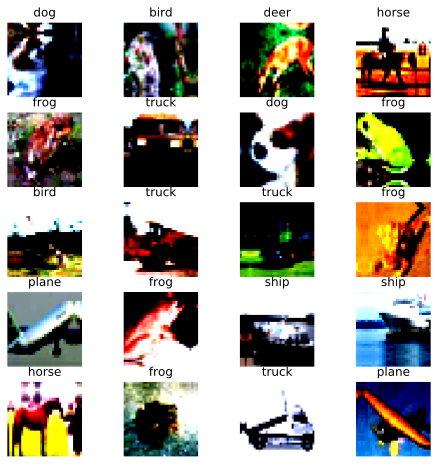

In [12]:
plot_img()

# save and load checkpoint

In [0]:
def save_checkpoint(model, is_best, filename='data/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [0]:
def load_checkpoint(model, filename = 'data/checkpoint.pth.tar'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()):
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

# Global variables

In [0]:
train_loss = 0.0
test_loss = 0.0
best_acc = 0.0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

In [0]:
total = 0
correct = 0

# Helper functions

In [0]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = target.size(0)
    total += batch_size    
    _, pred = output.max(dim=1)
    if is_test:
        preds.extend(pred)
    correct += torch.sum(pred == target.data)
    return (correct.float() / total) * 100

In [0]:
def reset():
    global total, correct
    global train_loss, test_loss, best_acc
    global trn_accs, trn_losses, val_accs, val_losses
    total, correct = 0, 0
    train_loss, test_loss, best_acc = 0.0, 0.0, 0.0
    trn_losses, trn_accs, val_accs, val_losses = [], [], [], []

In [0]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

# Train and Test

In [0]:
def train(epoch=0, model=None, optimizer=None):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98

    for i, (input, target) in enumerate(train_loader):
        bt_start = time.time()
        input, target = input.to(device), target.to(device)
        var_ip, var_tg = Variable(input), Variable(target)
                                    
        output = model(var_ip)
        loss = criterion(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
def test(model=None):
    with torch.no_grad():
        model.eval()
        global val_accs, val_losses
        running_loss = 0.
        avg_beta = 0.98
        for i, (input, target) in enumerate(test_loader):
            bt_start = time.time()
            input, target = input.to(device), target.to(device)
            var_ip, var_tg = Variable(input), Variable(target)
            output = model(var_ip)
            loss = criterion(output, var_tg)
        
            running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss.item(), prec, time.time()-bt_start)
        
            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [0]:
def fit(model=None, optimizer=None, sched=None):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    for j in range(epochs):
        train(j, model, optimizer)
        test(model)
        if sched:
          sched.step(j)
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_losses[-1], val_losses[-1], trn_accs[-1], val_accs[-1]))

# Model

In [23]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
  6%|▋         | 2.83M/44.7M [00:00<00:01, 29.6MB/s]
 52%|█████▏    | 23.2M/44.7M [00:00<00:00, 39.9MB/s]
 97%|█████████▋| 43.2M/44.7M [00:00<00:00, 52.7MB/s]
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s] 

In [0]:
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10, bias=True)

In [25]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in model.parameters():
  param.requires_grad = True

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4, momentum=0.9)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)

In [0]:
save_checkpoint(model, True, filename='before_sgd_resnet18.pth.tar')

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
reset()

In [0]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.79313249	0.74132563	66.39599609	67.74333191
2	0.64829487	0.69601622	71.70090485	72.15666962
3	0.57526764	0.55291760	74.33882141	74.75055695
4	0.54393889	0.54045472	76.20870209	76.45500183
5	0.49835263	0.50361715	77.51206970	77.70300293
6	0.46420780	0.49422138	78.58942413	78.72583008
7	0.45107309	0.49169979	79.45463562	79.55451965
8	0.41838781	0.46016596	80.17276764	80.25228882
9	0.39948578	0.47960735	80.82415009	80.87444305
10	0.38481720	0.46406015	81.36254120	81.41949463
11	0.37888035	0.46209894	81.86215973	81.90515900
12	0.35764240	0.49648709	82.33126068	82.34652710
13	0.34535255	0.44940313	82.72687531	82.74948883
14	0.34110329	0.44997972	83.10205078	83.13071442
15	0.32506131	0.50102261	83.45652008	83.46256256
16	0.31396908	0.47125938	83.77588654	83.78469086
17	0.29703725	0.44831329	84.07327271	84.08509827
18	0.28847559	0.46605055	84.36186981	84.36953735
19	0.26968112	0.46469901	84.62699127	84.63517761
20	0.27772126	0.47915473	84.88411713	

In [0]:
save_checkpoint(model, True, 'sgd_resnet18_9330.pth.tar')

In [0]:
ep_sgd_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_sgd_losses.append(train_stats.losses[i])
        
ep_sgd_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_sgd_lossesv.append(test_stats.losses[i])

In [0]:
ep_sgd_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_sgd_accs.append(train_stats.precs[i])
        
ep_sgd_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_sgd_accsv.append(test_stats.precs[i])

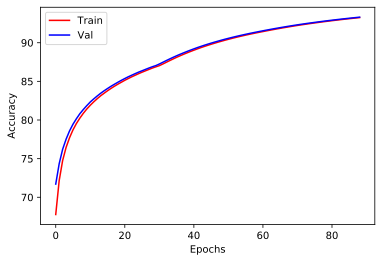

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_sgd_accs, 'r', label='Train')
plt.plot(ep_sgd_accsv, 'b', label='Val')
plt.legend()
plt.savefig('sgd_resnet18_9330_acc.jpg')

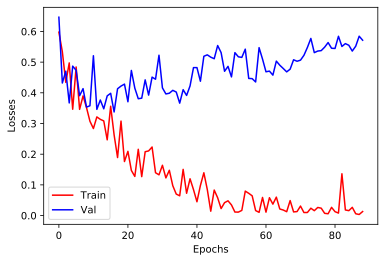

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_sgd_losses, 'r', label='Train')
plt.plot(ep_sgd_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('sgd_resnet18_9330_loss.jpg')

In [0]:
from google.colab import files
files.download('./sgd_resnet18_9330.pth.tar')
files.download('./sgd_resnet18_9330_acc.jpg')
files.download('./sgd_resnet18_9330_loss.jpg')

# ADAMW

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
reset()

In [0]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

In [0]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.85013218	0.73820112	61.88399887	63.94333267
2	0.68763721	0.60742203	69.11545563	69.92750549
3	0.59119868	0.56625939	72.55647278	73.00778198
4	0.54223408	0.52267484	74.78478241	75.10124969
5	0.49131328	0.50490741	76.43138123	76.65533447
6	0.45364076	0.50395180	77.73428345	77.88972473
7	0.41434392	0.49108689	78.77463531	78.89309692
8	0.39298269	0.49514570	79.67872620	79.76708221
9	0.37476659	0.48024492	80.44981384	80.52166748
10	0.35891538	0.47812114	81.15677643	81.21416473
11	0.32745018	0.47881951	81.76569366	81.80788422
12	0.31069746	0.48954680	82.32915497	82.35777283
13	0.30159125	0.47937265	82.83116913	82.85474396
14	0.28103011	0.48615615	83.29578400	83.31571198
15	0.27771957	0.47482704	83.74247742	83.76033020
16	0.25743926	0.47146901	84.16210175	84.17302704
17	0.25000483	0.49392118	84.53821564	84.54343414
18	0.24719775	0.50725957	84.89345551	84.89398193
19	0.22206496	0.49611363	85.22557831	85.22579193
20	0.21006189	0.51358514	85.53176880	

In [0]:
save_checkpoint(model, True, 'adamw_resnet18_9277.pth.tar')

In [0]:
ep_adamw_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_adamw_losses.append(train_stats.losses[i])
        
ep_adamw_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_adamw_lossesv.append(test_stats.losses[i])

In [0]:
ep_adamw_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_adamw_accs.append(train_stats.precs[i])
        
ep_adamw_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_adamw_accsv.append(test_stats.precs[i])

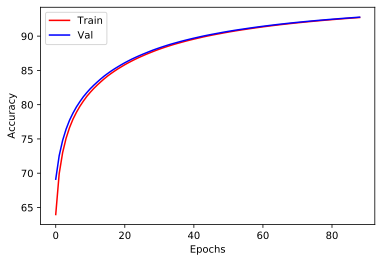

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_adamw_accs, 'r', label='Train')
plt.plot(ep_adamw_accsv, 'b', label='Val')
plt.legend()
plt.savefig('adamw_resnet18_9277_acc.jpg')

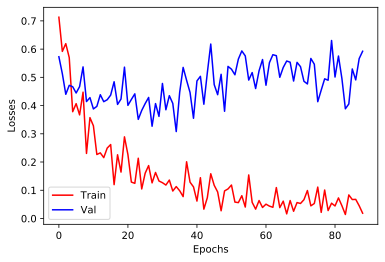

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_adamw_losses, 'r', label='Train')
plt.plot(ep_adamw_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('adamw_resnet18_9277_loss.jpg')

In [0]:
from google.colab import files
files.download('./adamw_resnet18_9277.pth.tar')
files.download('./adamw_resnet18_9277_acc.jpg')
files.download('./adamw_resnet18_9277_loss.jpg')

# Lookahead with SGD

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optims = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [0]:
sched_la = torch.optim.lr_scheduler.StepLR(optims, step_size=30, gamma=0.2)

In [0]:
la_optim = Lookahead(optims, alpha=0.5, k=10)

In [0]:
fit(model, la_optim, sched_la)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.80412821	0.67540877	65.55999756	67.44499969
2	0.66217067	0.58627998	71.49272919	72.21833801
3	0.57036327	0.54968659	74.33705902	74.73944092
4	0.52546535	0.52136333	76.20521545	76.47208405
5	0.48797978	0.52578297	77.59517670	77.74566650
6	0.45466794	0.52268913	78.67485809	78.78138733
7	0.44103390	0.51987436	79.53073120	79.59832764
8	0.43288209	0.54712344	80.27595520	80.31375122
9	0.39000792	0.51206695	80.90849304	80.95500183
10	0.38323111	0.46767378	81.46084595	81.52149963
11	0.35768960	0.46104806	82.00984955	82.06697083
12	0.34646576	0.46351539	82.48830414	82.52639008
13	0.31617146	0.46825647	82.93545532	82.95871735
14	0.30741357	0.47725594	83.32891846	83.34714508
15	0.29908946	0.51705303	83.69853973	83.70611572
16	0.29979351	0.50682819	84.03672791	84.03812408
17	0.26345370	0.53779406	84.35950470	84.35304260
18	0.26686016	0.52753349	84.64569855	84.64037323
19	0.25963379	0.49933115	84.91690063	84.91438293
20	0.24406346	0.46621495	85.18235779	

In [0]:
save_checkpoint(model, True, 'lookahead_sgd_resnet18_9336.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

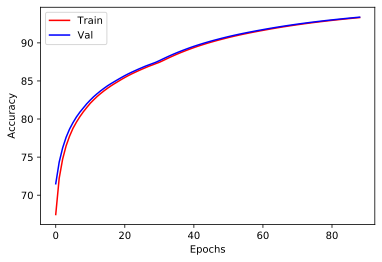

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('lookahead_sgd_resnet18_9336_acc.jpg')

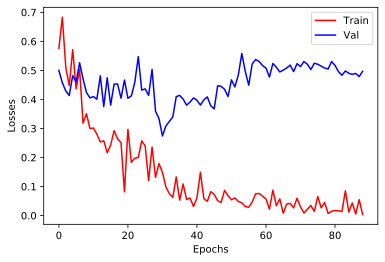

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('lookahead_sgd_resnet18_9336_loss.jpg')

In [0]:
from google.colab import files
files.download('./lookahead_sgd_resnet18_9336.pth.tar')
files.download('./lookahead_sgd_resnet18_9336_acc.jpg')
files.download('./lookahead_sgd_resnet18_9336_loss.jpg')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 35828, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# RAdam

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optimizer = RAdam( model.parameters(), lr=1e-4, weight_decay=1e-1)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)

In [0]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	1.17103652	1.04456021	41.75599670	45.49499893
2	0.86184681	0.77707684	55.59727097	57.11083221
3	0.72119151	0.67261847	61.94058609	62.78555298
4	0.64092174	0.59949302	65.96261597	66.53375244
5	0.56243319	0.55623573	68.81655121	69.21533203
6	0.52930620	0.54810457	70.96142578	71.24583435
7	0.48743979	0.51196633	72.68366241	72.92761993
8	0.46908906	0.50594005	74.11425781	74.30020905
9	0.44485717	0.49418168	75.33792114	75.49111176
10	0.39754846	0.48649221	76.39373016	76.52466583
11	0.38853284	0.49979419	77.33507538	77.43742371
12	0.35277096	0.47928442	78.17619324	78.25888824
13	0.34195214	0.47881888	78.91259003	78.98653412
14	0.32298536	0.48684639	79.59421539	79.65309143
15	0.29404765	0.48961397	80.21977997	80.27278137
16	0.29296536	0.49782645	80.78904724	80.82979584
17	0.27651679	0.48747552	81.31484985	81.35372925
18	0.27250822	0.48827815	81.80316925	81.83573914
19	0.24975174	0.49880514	82.27380371	82.29859161
20	0.23640815	0.48936872	82.70151520	

In [0]:
save_checkpoint(model, True, 'radam_resnet18_9302.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

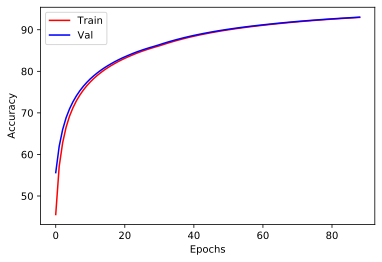

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('radam_resnet18_9302_acc.jpg')

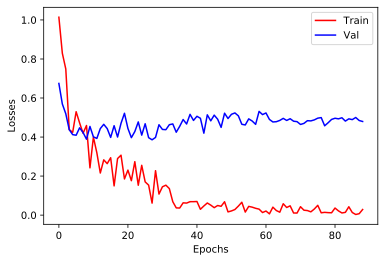

In [0]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('radam_resnet18_9302_loss.jpg')

In [0]:
from google.colab import files
files.download('./radam_resnet18_9302.pth.tar')
files.download('./radam_resnet18_9302_acc.jpg')
files.download('./radam_resnet18_9302_loss.jpg')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 59682, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# Lookahead with radam

In [0]:
load_checkpoint(model, filename='before_sgd_resnet18.pth.tar')

In [0]:
reset()

In [0]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
optim = RAdam( model.parameters(), lr=1e-3, weight_decay=1e-4)

In [0]:
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=30, gamma=0.2)

In [0]:
optimizer = Lookahead(optim, alpha=0.5, k=10)

In [37]:
fit(model, optimizer, sched)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1	0.84970677	0.71778688	58.85800171	61.55999756
2	0.69664995	0.60272739	67.87818146	68.87333679
3	0.59945265	0.55649941	71.80059052	72.31111145
4	0.56007283	0.54820792	74.09957123	74.39791870
5	0.52714975	0.56799161	75.69138336	75.85766602
6	0.49470810	0.58072263	76.85285950	76.97444916
7	0.47242748	0.55495768	77.79829407	77.88975525
8	0.44865313	0.57384148	78.60936737	78.64521027
9	0.45181180	0.60109896	79.24471283	79.24462891
10	0.41533526	0.44392665	79.80440521	79.89366913
11	0.40102104	0.45208262	80.38661194	80.45803070
12	0.39814142	0.46110680	80.90126801	80.95444489
13	0.38534148	0.46938068	81.35987091	81.40948486
14	0.36481857	0.54749257	81.78047943	81.78952026
15	0.33921807	0.47814232	82.15618134	82.18477631
16	0.33558479	0.48380847	82.52516174	82.54125214
17	0.32106344	0.50848424	82.85960388	82.87235260
18	0.31863529	0.50099569	83.17149353	83.18379211
19	0.30196240	0.50486462	83.47628021	83.48508453
20	0.29221481	0.42451117	83.76496124	

In [0]:
save_checkpoint(model, True, 'radam_lookahead_resnet18_9320.pth.tar')

In [0]:
ep_lookahead_losses = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_losses.append(train_stats.losses[i])
        
ep_lookahead_lossesv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_lossesv.append(test_stats.losses[i])

In [0]:
ep_lookahead_accs = []
for i in range(0, len(train_stats.losses), len(train_loader)):
    if i != 0 :
        ep_lookahead_accs.append(train_stats.precs[i])
        
ep_lookahead_accsv = []
for i in range(0, len(test_stats.losses), len(test_loader)):
    if(i != 0):
        ep_lookahead_accsv.append(test_stats.precs[i])

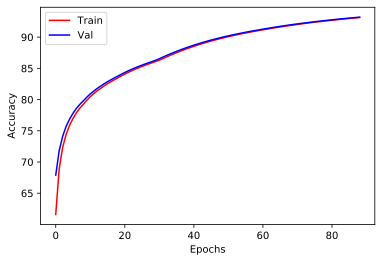

In [41]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(ep_lookahead_accs, 'r', label='Train')
plt.plot(ep_lookahead_accsv, 'b', label='Val')
plt.legend()
plt.savefig('radam_lookahead_resnet18_9320_acc.jpg')

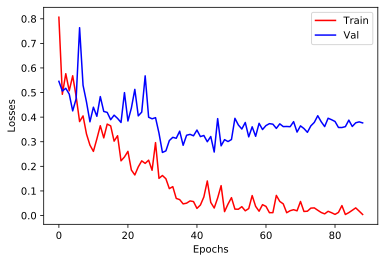

In [42]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(ep_lookahead_losses, 'r', label='Train')
plt.plot(ep_lookahead_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('radam_lookahead_resnet18_9320_loss.jpg')

In [0]:
from google.colab import files
files.download('./radam_lookahead_resnet18_9320.pth.tar')
files.download('./radam_lookahead_resnet18_9320_acc.jpg')
files.download('./radam_lookahead_resnet18_9320_loss.jpg')